### Домашнее задание по лекции "Компьютерное зрение 1" DLL  

Решить задачу детекции на основе SSD для датасета https://github.com/Shenggan/BCCD_Dataset  
Реализацию SSD можно подглядеть тут - https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

In [55]:
import json
import os
import torch
import random
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT
import numpy as np
import matplotlib.pyplot as plt
import torchvision
#from torchvision import models
from torch import nn
from math import sqrt
import time
import torch.nn.functional as F
from torchvision import transforms

from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageFont
from utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
voc_labels = ('rbc', 'wbc', 'platelets')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

# Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}
data_folder = "BCCD_Dataset-master/BCCD"
bccd_labels = ('background','rbc', 'wbc', 'platelets')

In [4]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = list()
    labels = list()
    difficulties = list()
    for object in root.iter('object'):

        difficult = int(object.find('difficult').text == '1')

        label = object.find('name').text.lower().strip()
        if label not in label_map:
            continue

        bbox = object.find('bndbox')
        xmin = int(bbox.find('xmin').text) - 1
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)

    return {'boxes': boxes, 'labels': labels, 'difficulties': difficulties}


def create_data_lists(voc07_path, voc12_path, output_folder):
    """
    Create lists of images, the bounding boxes and labels of the objects in these images, and save these to file.
    :param voc07_path: path to the 'VOC2007' folder
    :param voc12_path: path to the 'VOC2012' folder
    :param output_folder: folder where the JSONs must be saved
    """
    voc07_path = os.path.abspath(voc07_path)
    voc12_path = os.path.abspath(voc12_path)

    train_images = list()
    train_objects = list()
    n_objects = 0

    # Training data
    for path in [voc07_path, voc12_path]:

        # Find IDs of images in training data
        with open(os.path.join(path, 'ImageSets/Main/trainval.txt')) as f:
            ids = f.read().splitlines()

        for id in ids:
            # Parse annotation's XML file
            objects = parse_annotation(os.path.join(path, 'Annotations', id + '.xml'))
            if len(objects['boxes']) == 0:
                continue
            n_objects += len(objects)
            train_objects.append(objects)
            train_images.append(os.path.join(path, 'JPEGImages', id + '.jpg'))

    assert len(train_objects) == len(train_images)

    # Save to file
    with open(os.path.join(output_folder, 'TRAIN_images.json'), 'w') as j:
        json.dump(train_images, j)
    with open(os.path.join(output_folder, 'TRAIN_objects.json'), 'w') as j:
        json.dump(train_objects, j)
    with open(os.path.join(output_folder, 'label_map.json'), 'w') as j:
        json.dump(label_map, j)  # save label map too

    print('\nThere are %d training images containing a total of %d objects. Files have been saved to %s.' % (
        len(train_images), n_objects, os.path.abspath(output_folder)))

    # Test data
    test_images = list()
    test_objects = list()
    n_objects = 0

    # Find IDs of images in the test data
    with open(os.path.join(voc07_path, 'ImageSets/Main/test.txt')) as f:
        ids = f.read().splitlines()

    for id in ids:
        # Parse annotation's XML file
        objects = parse_annotation(os.path.join(voc07_path, 'Annotations', id + '.xml'))
        if len(objects) == 0:
            continue
        test_objects.append(objects)
        n_objects += len(objects)
        test_images.append(os.path.join(voc07_path, 'JPEGImages', id + '.jpg'))

    assert len(test_objects) == len(test_images)

    # Save to file
    with open(os.path.join(output_folder, 'TEST_images.json'), 'w') as j:
        json.dump(test_images, j)
    with open(os.path.join(output_folder, 'TEST_objects.json'), 'w') as j:
        json.dump(test_objects, j)

    print('\nThere are %d test images containing a total of %d objects. Files have been saved to %s.' % (
        len(test_images), n_objects, os.path.abspath(output_folder)))


def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.
    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.
    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor


def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels) == len(
        true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = len(label_map)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision


def xy_to_cxcy(xy):
    """
    Convert bounding boxes from boundary coordinates (x_min, y_min, x_max, y_max) to center-size coordinates (c_x, c_y, w, h).
    :param xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).
    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.
    In the model, we are predicting bounding box coordinates in this encoded form.
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.
    They are decoded into center-size coordinates.
    This is the inverse of the function above.
    :param gcxgcy: encoded bounding boxes, i.e. output of the model, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding is defined, a tensor of size (n_priors, 4)
    :return: decoded bounding boxes in center-size form, a tensor of size (n_priors, 4)
    """

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h


def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)


# Some augmentation functions below have been adapted from
# From https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py

def expand(image, boxes, filler):
    """
    Perform a zooming out operation by placing the image in a larger canvas of filler material.
    Helps to learn to detect smaller objects.
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param filler: RBG values of the filler material, a list like [R, G, B]
    :return: expanded image, updated bounding box coordinates
    """
    # Calculate dimensions of proposed expanded (zoomed-out) image
    original_h = image.size(1)
    original_w = image.size(2)
    max_scale = 4
    scale = random.uniform(1, max_scale)
    new_h = int(scale * original_h)
    new_w = int(scale * original_w)

    # Create such an image with the filler
    filler = torch.FloatTensor(filler)  # (3)
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)  # (3, new_h, new_w)
    # Note - do not use expand() like new_image = filler.unsqueeze(1).unsqueeze(1).expand(3, new_h, new_w)
    # because all expanded values will share the same memory, so changing one pixel will change all

    # Place the original image at random coordinates in this new image (origin at top-left of image)
    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image

    # Adjust bounding boxes' coordinates accordingly
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(
        0)  # (n_objects, 4), n_objects is the no. of objects in this image

    return new_image, new_boxes


def random_crop(image, boxes, labels):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """
    original_h = image.size(1)
    original_w = image.size(2)
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        # Randomly draw the value for minimum overlap
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels

        # Try up to 50 times for this choice of minimum overlap
        # This isn't mentioned in the paper, of course, but 50 is chosen in paper authors' original Caffe repo
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            # Note - it's [0.1, 1] in the paper, but actually [0.3, 1] in the authors' repo
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0),
                                           boxes)  # (1, n_objects), n_objects is the no. of objects in this image
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels


def flip(image, boxes):
    """
    Flip image horizontally.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes


def resize(image, boxes, dims=(300, 300), return_percent_coords=True):
    """
    Resize image. For the SSD300, resize to (300, 300).
    Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
    you may choose to retain them.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    # Resize image
    new_image = FT.resize(image, dims)

    # Resize bounding boxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes = boxes / old_dims  # percent coordinates

    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims

    return new_image, new_boxes


def photometric_distort(image):
    """
    Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.
    :param image: image, a PIL Image
    :return: distorted image
    """
    new_image = image

    distortions = [FT.adjust_brightness,
                   FT.adjust_contrast,
                   FT.adjust_saturation,
                   FT.adjust_hue]

    random.shuffle(distortions)

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ == 'adjust_hue':
                # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:
                # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
                adjust_factor = random.uniform(0.5, 1.5)

            # Apply this distortion
            new_image = d(new_image, adjust_factor)

    return new_image


def transform(image, boxes, labels, split):
    """
    Apply the transformations above.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :param split: one of 'TRAIN' or 'TEST', since different sets of transformations are applied
    :return: transformed image, transformed bounding box coordinates, transformed labels, transformed difficulties
    """
    assert split in {'TRAIN', 'TEST'}

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    new_image = image
    new_boxes = boxes
    new_labels = labels
    # Skip the following operations for evaluation/testing
    if split == 'TRAIN':
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = FT.to_tensor(new_image)

        # Expand image (zoom out) with a 50% chance - helpful for training detection of small objects
        # Fill surrounding space with the mean of ImageNet data that our base VGG was trained on
        if random.random() < 0.5:
            new_image, new_boxes = expand(new_image, boxes, filler=mean)

        # Randomly crop image (zoom in)
        new_image, new_boxes, new_labels = random_crop(new_image, new_boxes, new_labels)

        # Convert Torch tensor to PIL image
        new_image = FT.to_pil_image(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (300, 300) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=mean, std=std)

    return new_image, new_boxes, new_labels


def adjust_learning_rate(optimizer, scale):
    """
    Scale learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param scale: factor to multiply learning rate with.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * scale
    print("DECAYING learning rate.\n The new LR is %f\n" % (optimizer.param_groups[1]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)


def save_checkpoint(epoch, model, optimizer):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer}
    filename = 'checkpoint_ssd300.pth.tar'
    torch.save(state, filename)


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [5]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder

        # Read data files
        im = []
        with open(os.path.join(data_folder + "/ImageSets/Main/" + split.lower() + '.txt'), 'r') as j:
            for line in j:
                im.append(line.rstrip())
        self.images = im

    def __getitem__(self, i):
        # Read image
        image = Image.open(data_folder + '/JPEGImages/' + self.images[i] + '.jpg', mode='r')
        image = image.convert('RGB')
        id_ = self.images[i]

        anno = ET.parse(
            os.path.join(self.data_folder, 'Annotations', id_ + '.xml'))
        boxes = []
        labels = []
        
        for obj in anno.findall('object'):
            bndbox_anno = obj.find('bndbox')
            boxes.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('xmin','ymin', 'xmax', 'ymax')])
            name = obj.find('name').text.lower().strip()
            labels.append(bccd_labels.index(name))

        boxes = np.stack(boxes).astype(np.float32)
        boxes = torch.FloatTensor(boxes)
        labels = np.stack(labels).astype(np.int32)
        labels = torch.LongTensor(labels) 

        # Apply transformations
        image, boxes, labels = transform(image, boxes, labels, split=self.split)

        return image, boxes, labels


    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [19]:
class VGGBase(nn.Module):

    def __init__(self):
        super(VGGBase, self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True) 

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.load_pretrained_layers()

    def forward(self, image):
        out = F.relu(self.conv1_1(image)) 
        out = F.relu(self.conv1_2(out))  
        out = self.pool1(out)  

        out = F.relu(self.conv2_1(out))  
        out = F.relu(self.conv2_2(out))  
        out = self.pool2(out)  

        out = F.relu(self.conv3_1(out))  
        out = F.relu(self.conv3_2(out))  
        out = F.relu(self.conv3_3(out))  
        out = self.pool3(out)  

        out = F.relu(self.conv4_1(out))  
        out = F.relu(self.conv4_2(out))  
        out = F.relu(self.conv4_3(out))  
        conv4_3_feats = out  
        out = self.pool4(out)  

        out = F.relu(self.conv5_1(out))  
        out = F.relu(self.conv5_2(out))  
        out = F.relu(self.conv5_3(out))  
        out = self.pool5(out)  

        out = F.relu(self.conv6(out))  

        conv7_feats = F.relu(self.conv7(out))  

        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):

        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        for i, param in enumerate(param_names[:-4]): 
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  

        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1) 
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias'] 
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None]) 
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  

        self.load_state_dict(state_dict)

        print("\nМодель загружена.\n")
        

class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0) 
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  
        
        self.init_conv2d()
        
    def init_conv2d(self):

        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
        
    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats)) 
        out = F.relu(self.conv8_2(out))  
        conv8_2_feats = out  

        out = F.relu(self.conv9_1(out))  
        out = F.relu(self.conv9_2(out))  
        conv9_2_feats = out  

        out = F.relu(self.conv10_1(out))  
        out = F.relu(self.conv10_2(out))  
        conv10_2_feats = out  

        out = F.relu(self.conv11_1(out))  
        conv11_2_feats = F.relu(self.conv11_2(out)) 

        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats
    
class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes 
        
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)
        
        self.init_conv2d()
        
    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)

        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  

        l_conv7 = self.loc_conv7(conv7_feats) 
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  
        l_conv7 = l_conv7.view(batch_size, -1, 4)  

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous() 
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous() 
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  

        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  

        c_conv7 = self.cl_conv7(conv7_feats)  
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats) 
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous() 
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes) 

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous() 
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes) 

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats) 
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous() 
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  

        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  

        return locs, classes_scores
    
    
# SSD строим на основе VGG  
    
class SSD(nn.Module):
    def __init__(self, n_classes=2):
        super(SSD, self).__init__()
        self.n_classes = n_classes
        
        self.base = VGGBase().cuda()
        self.aux_convs = AuxiliaryConvolutions().cuda()
        self.pred_convs = PredictionConvolutions(n_classes).cuda()
        
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  
        nn.init.constant_(self.rescale_factors, 20)

        self.priors_cxcy = self.create_prior_boxes()
        
    def forward(self, image):
        conv4_3_feats, conv7_feats = self.base(image) 

        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt() 
        conv4_3_feats = conv4_3_feats / norm 
        conv4_3_feats = conv4_3_feats * self.rescale_factors  

        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  

        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats) 

        return locs, classes_scores

    
    def create_prior_boxes(self):

        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).cuda() 
        prior_boxes.clamp_(0, 1)  

        return prior_boxes
    
    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  

        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy)) 

            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1) 

            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]  
                score_above_min_score = class_scores > min_score  
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  
                class_decoded_locs = decoded_locs[score_above_min_score] 

                class_scores, sort_ind = class_scores.sort(dim=0, descending=True) 
                class_decoded_locs = class_decoded_locs[sort_ind] 

                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)

                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).cuda()  

                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue

                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    suppress[box] = 0

                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).cuda())
                image_scores.append(class_scores[1 - suppress])

            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).cuda())
                image_labels.append(torch.LongTensor([0]).cuda())
                image_scores.append(torch.FloatTensor([0.]).cuda())

            image_boxes = torch.cat(image_boxes, dim=0)  
            image_labels = torch.cat(image_labels, dim=0) 
            image_scores = torch.cat(image_scores, dim=0)  
            n_objects = image_scores.size(0)

            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  
                image_boxes = image_boxes[sort_ind][:top_k]  
                image_labels = image_labels[sort_ind][:top_k]  


            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  
    
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).cuda()  
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).cuda()  

        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  

            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  
            _, prior_for_each_object = overlap.max(dim=1)  
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).cuda()
            overlap_for_each_prior[prior_for_each_object] = 1.

            label_for_each_prior = labels[i][object_for_each_prior]  
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  

            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)

        positive_priors = true_classes != 0  

        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  

        n_positives = positive_priors.sum(dim=1)  
        n_hard_negatives = self.neg_pos_ratio * n_positives 

        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  

        conf_loss_pos = conf_loss_all[positive_priors]  

        conf_loss_neg = conf_loss_all.clone()  
        conf_loss_neg[positive_priors] = 0.  
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).cuda() 
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  

        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  

        return conf_loss + self.alpha * loc_loss

In [44]:
# Data parameters
# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 8  # batch size
epochs = 30
workers = 0  # number of workers for loading data in the DataLoader
print_freq = 26  # print training status every __ batches
lr = 2 * 1e-4  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

In [39]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f}'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss = losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored

In [45]:
# Initialize model
if checkpoint is None:
    start_epoch = 0
    model = SSD(n_classes=n_classes)
            # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Move to default device
model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Custom dataloaders
train_dataset = PascalVOCDataset(data_folder, split='train')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=train_dataset.collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

    # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
    # To convert iterations to epochs, divide iterations by the number of iterations per epoch
    # The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations


    # Epochs
for epoch in range(start_epoch, epochs):

        # Decay learning rate at particular epochs
    

        # One epoch's training
    train(train_loader=train_loader,model=model,criterion=criterion,optimizer=optimizer,epoch=epoch)

        # Save checkpoint
    save_checkpoint(epoch, model, optimizer)


Модель загружена.

Epoch: [0]	Batch Time 1.213 (1.213)	Data Time 0.837 (0.837)	Loss 15.8508
Epoch: [1]	Batch Time 0.987 (0.987)	Data Time 0.638 (0.638)	Loss 7.1435
Epoch: [2]	Batch Time 0.752 (0.752)	Data Time 0.400 (0.400)	Loss 6.3868
Epoch: [3]	Batch Time 0.777 (0.777)	Data Time 0.424 (0.424)	Loss 6.0441
Epoch: [4]	Batch Time 0.761 (0.761)	Data Time 0.399 (0.399)	Loss 5.5376
Epoch: [5]	Batch Time 0.855 (0.855)	Data Time 0.487 (0.487)	Loss 4.8036
Epoch: [6]	Batch Time 0.812 (0.812)	Data Time 0.458 (0.458)	Loss 4.3193
Epoch: [7]	Batch Time 0.970 (0.970)	Data Time 0.617 (0.617)	Loss 4.0891
Epoch: [8]	Batch Time 0.784 (0.784)	Data Time 0.429 (0.429)	Loss 4.2681
Epoch: [9]	Batch Time 0.821 (0.821)	Data Time 0.470 (0.470)	Loss 3.7281
Epoch: [10]	Batch Time 0.866 (0.866)	Data Time 0.513 (0.513)	Loss 4.1407
Epoch: [11]	Batch Time 1.031 (1.031)	Data Time 0.667 (0.667)	Loss 4.0519
Epoch: [12]	Batch Time 0.805 (0.805)	Data Time 0.452 (0.452)	Loss 3.4738
Epoch: [13]	Batch Time 0.702 (0.702)	Dat

In [53]:
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.
    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image

In [9]:
original_image = Image.open('BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00033.jpg', mode='r')

C:\Users\cefeu\AppData\Local\Temp\ipykernel_29624\223368298.py:353: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  image_boxes.append(class_decoded_locs[1 - suppress])
C:\Users\cefeu\AppData\Local\Temp\ipykernel_29624\223368298.py:355: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  image_scores.append(class_scores[1 - suppress])


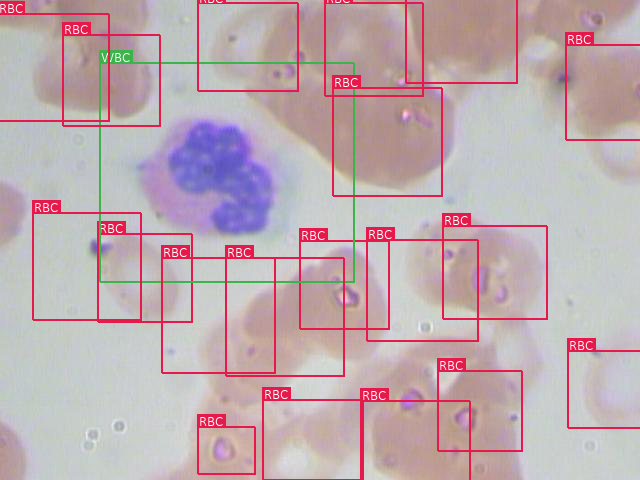

In [94]:
detect(original_image, min_score=0.1, max_overlap=0.3, top_k=20)

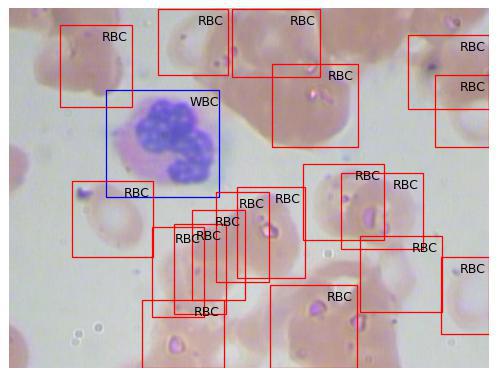

In [8]:
# Изображение полученное после запуска кода с github.com/Shenggan/BCCD_Dataset
Image.open('imagesBox/BloodImage_00033.jpg')

Результаты довольно разнятся)